# Direct Query Question Analysis

The 8 `adl-benchmark` questions were listed [here](README.md). The details of the models used to run over them can be found [here](models.yaml). This notebook is an analysis of the results.

In [35]:
import re

import matplotlib.pyplot as plt
import pandas as pd
import yaml

The CSV results are written into all the `direct-question-xx.md` files found in this same directory. Use the following command to build a `results.csv` file which we can read in:

```bash
python ./notebooks/adl-benchmarks/query-results-to-pandas.py ./notebooks/adl-benchmarks/direct-question-*.md
```

In [36]:
data = pd.read_csv("../../results.csv")
data.describe()

,Time,PromptTokens,CompletionTokens,TotalTokens,Estimated Cost,Attempts
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,69.061635,26945.673077,5205.509615,32151.182692,0.044625,2.105769
std,63.246728,12573.543038,6045.761022,16759.170674,0.049496,0.912888
min,4.290000,11639.000000,518.000000,12158.000000,0.001000,1.000000
25%,15.432500,11929.500000,1383.500000,14029.500000,0.009500,1.000000
50%,51.750000,26238.500000,3438.000000,30098.000000,0.025000,2.000000
75%,107.765000,38731.500000,6101.250000,44900.250000,0.065000,3.000000
max,319.660000,47529.000000,33525.000000,72598.000000,0.220000,3.000000


## Preprocessing the data

You could argue this should be done in a support file. You'd be right.

In [39]:
# Turn the question number into something we can easily reason about
data['question'] = data['source_file'].apply(lambda x: int(re.search(r'direct-question-(\d+)', x).group(1)))

In [47]:
# Load models.yaml so that we can get from the detailed model name to the "nick-name"
with open("models.yaml", "r") as f:
    models = yaml.safe_load(f)["models"]

nickname_lookup = {models[name]["model_name"]: name for name in models.keys()}
data['model_nickname'] = data['Model'].map(nickname_lookup)

In [48]:
data.columns

Index(['Model', 'Time', 'PromptTokens', 'CompletionTokens', 'TotalTokens',
       'Estimated Cost', 'Attempts', 'Result', 'source_file', 'question',
       'model_nickname'],
      dtype='object')

## Model Cost

These models have a wide range of costs! The individual costs need to be pulled from the `models.yaml` file.

In [25]:
# Extract model names and output costs
model_costs = [(name, info.get('output_cost_per_million', 'N/A')) for name, info in models.items()]

model_info = pd.DataFrame(model_costs, columns=["model_name", "output_cost_per_million"])

In [26]:
model_info_sorted = model_info.sort_values(by="output_cost_per_million", ascending=False)
model_info_sorted

,model_name,output_cost_per_million
10,claude-sonnet-4,15.00
4,gpt-4o,10.00
1,gpt-5,10.00
0,gpt-4.1,8.00
5,o4-mini,4.40
11,gemini-2.5-flash,2.50
2,gpt-5-mini,2.00
8,Qwen3-Coder-480B,2.00
12,deepseek-chat-v3-0324,0.88
9,coder-large,0.80


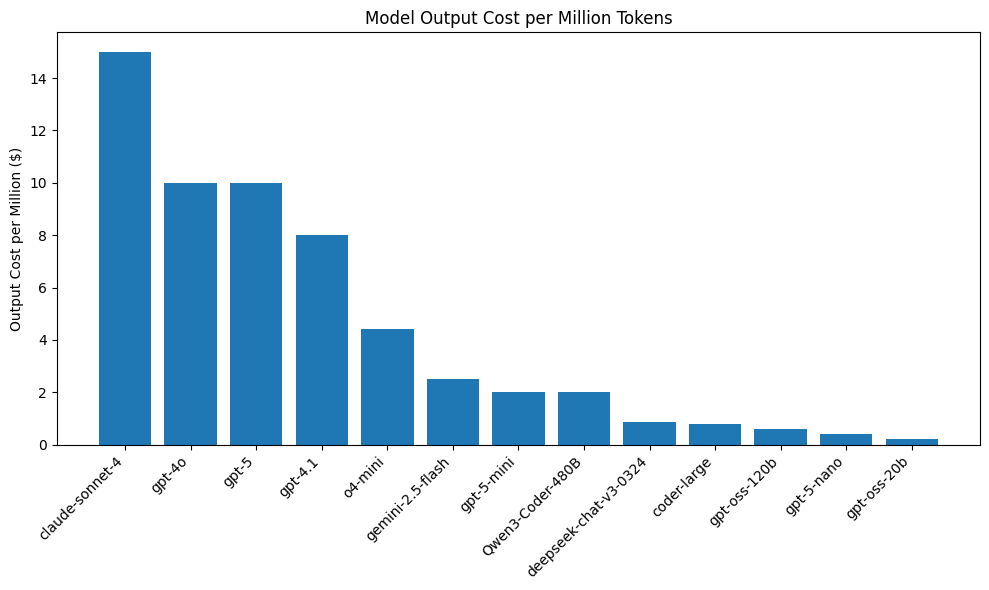

In [30]:
# Plot model costs
plt.figure(figsize=(10, 6))
plt.bar(model_info_sorted['model_name'], model_info_sorted['output_cost_per_million'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Output Cost per Million ($)')
plt.title('Model Output Cost per Million Tokens')
plt.tight_layout()
plt.show()

## Success and Attempts

Below is a xxxx

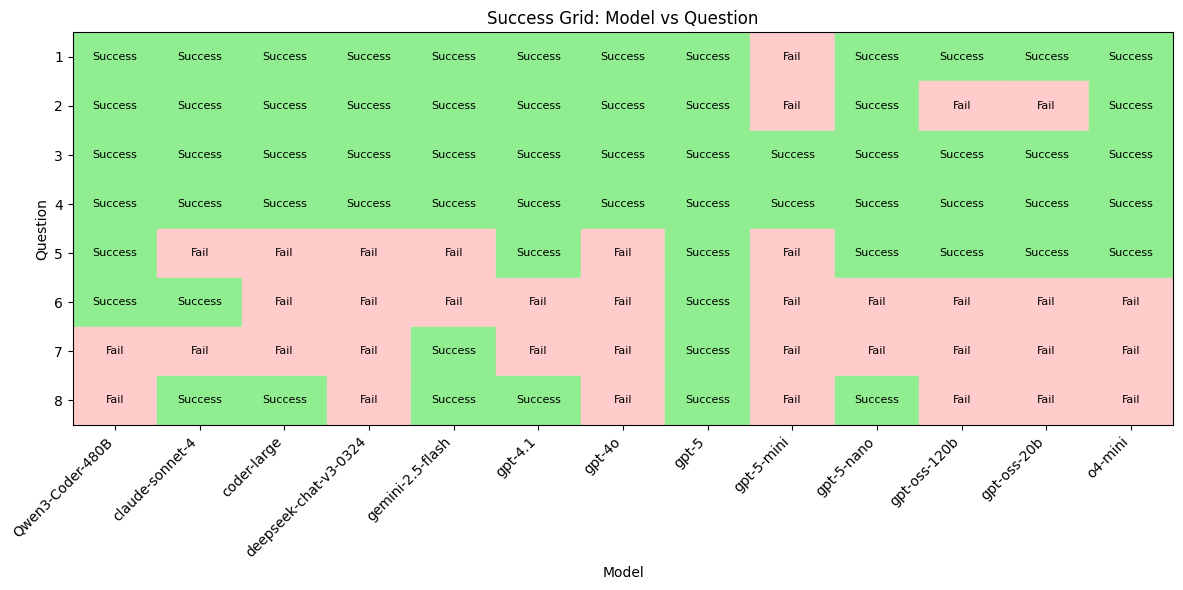

In [50]:
import numpy as np

# Prepare pivot table for grid
pivot = data.pivot(index='question', columns='model_nickname', values='Result')

# Map results to colors
color_map = pivot.map(lambda x: '#90ee90' if x == 'Success' else '#ffcccb')  # light green/red

fig, ax = plt.subplots(figsize=(12, 6))

for (i, question) in enumerate(pivot.index):
    for (j, model) in enumerate(pivot.columns):
        color = color_map.loc[question, model]
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))
        # Optionally, add text label
        ax.text(j + 0.5, i + 0.5, str(pivot.loc[question, model]), ha='center', va='center', fontsize=8)

ax.set_xticks(np.arange(len(pivot.columns)) + 0.5)
ax.set_xticklabels(pivot.columns, rotation=45, ha='right')
ax.set_yticks(np.arange(len(pivot.index)) + 0.5)
ax.set_yticklabels(pivot.index)
ax.set_xlim(0, len(pivot.columns))
ax.set_ylim(0, len(pivot.index))
ax.invert_yaxis()
ax.set_xlabel('Model')
ax.set_ylabel('Question')
ax.set_title('Success Grid: Model vs Question')
plt.tight_layout()
plt.show()